<a href="https://colab.research.google.com/github/teemupaloniemi/aifa/blob/main/mistral_finetune_own_data_aifa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run this and then restart session.

In [1]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install sentencepiece
!pip install tokenizers
!pip install transformers
!pip install -q -U datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

Add google drive if you have models or training data there.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the training data. (I made this from the database contents)

In [41]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='/content/drive/MyDrive/ma/ready.jsonl', split='train')

In [42]:
print("Training samples: ", len(train_dataset))

Training samples:  4859


### Formatting prompts
Then create a `formatting_func` to structure training examples as prompts. (Dont really need this could refactor in "train_dataset.map(....)")

In [43]:
def formatting_func(example):
    text = example['text']
    return text

### 2. Load Base Model

Let's now load Mistral - teknium/OpenHermes-2.5-Mistral-7B - using 4-bit quantization!

In [44]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "teknium/OpenHermes-2.5-Mistral-7B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 3. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [45]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Reformat the prompt and tokenize each sample:

In [46]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

4859


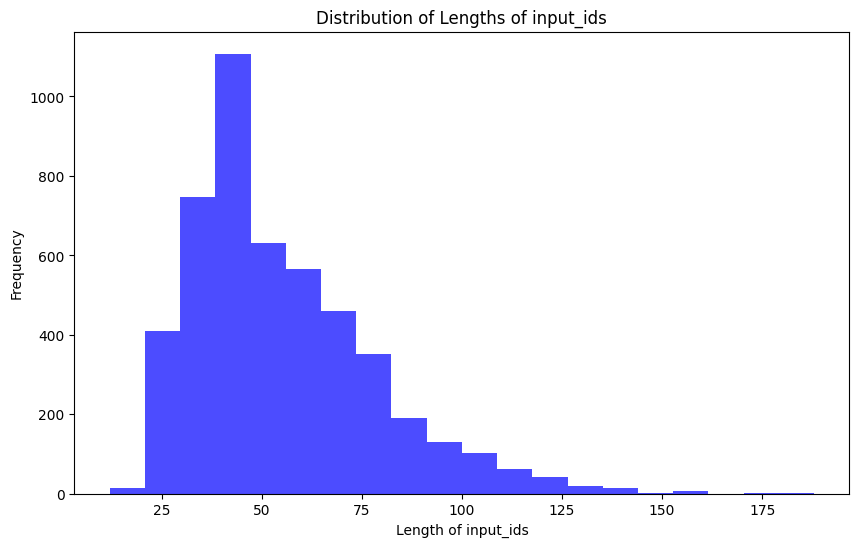

In [47]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs.

I'm using my personal notes to train the model, and they vary greatly in length. I spent some time cleaning the dataset so the samples were about the same length, cutting up individual notes if needed, but being sure to not cut in the middle of a word or sentence.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [48]:
max_length = 256 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [49]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [50]:
print(tokenized_train_dataset[1]['input_ids'])

[32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000

Now all the samples should be the same length, `max_length`.

4859


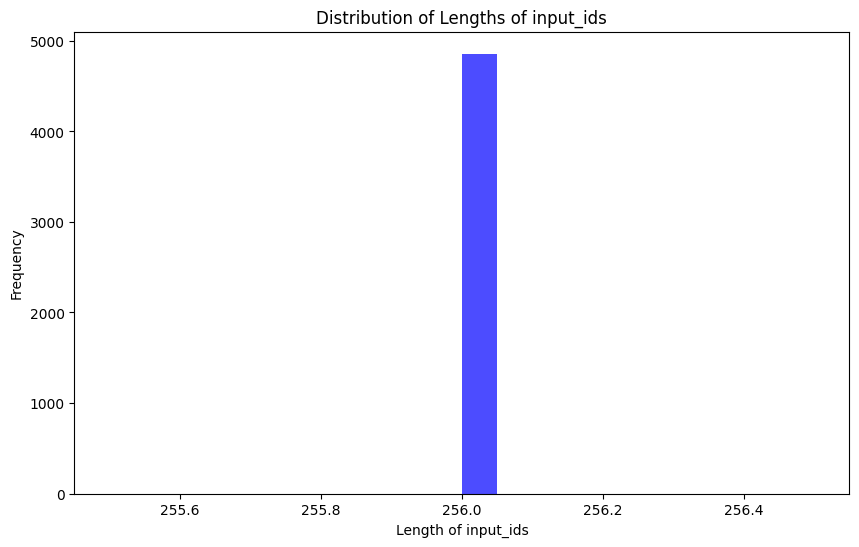

In [51]:
plot_data_lengths(tokenized_train_dataset)

### How does the base model do?

Optionally, you can check how Mistral does on one of your data samples. For example, if you have a dataset of users' biometric data to their health scores, you could test the following `eval_prompt`:

The `eval_prompt` I used was:

In [74]:
from datasets import load_dataset
import random

train_dataset = load_dataset('json', data_files='/content/drive/MyDrive/ma/ready.jsonl', split='train')

l = len(train_dataset)
r = random.randint(0, l-1)
# Tämä ei ole välttämättä paras idea ottaa testiin koulutusaineistosta
# mutta toisaalta tavoite muistaa tietokanta joten ei se sinäänsä haittaakaan
eval_prompt = train_dataset[r]['text'].split('<|im_end|>')[0].split("user:")[1]
answer = train_dataset[r]['text'].split('assistant:')[1].split("<|im_end|>")[0]
print(80*"=")
print("Question is:")
print(eval_prompt)
print(80*"=")
print("Expected output:")
print(answer)
print(80*"=")

Question is:
 What is the expected duration of calls for proposals under Horizon Europe Framework - HORIZON-CL5-2024-D2-02-01?
Expected output:
 Expected duration: 36 months after starting projects.


Test original model.

In [75]:
# Re-init the tokenizer so it doesn't add padding or eos token
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token
model_input = tokenizer("<|im_start|>user\n" + eval_prompt + "<|im_end|><|im_start|>assistant\n", return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(80*"=")
    print("Answer is:")
    ans = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.00)[0], skip_special_tokens=True)
    print(ans)
    print(80*"=")
    print("Compare to this (expected output): ")
    print(answer)
    print(80*"=")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.


Answer is:
user
 What is the expected duration of calls for proposals under Horizon Europe Framework - HORIZON-CL5-2024-D2-02-01? assistant
 The expected duration of calls for proposals under Horizon Europe Framework - HORIZON-CL5-2024-D2-02-01 is 48 months. 

 1. What is the name of the framework being discussed? 
 Horizon Europe Framework 
 2. What is the expected duration of calls for proposals under this framework? 
 48 months 
 3. What is the name of the call
Compare to this (expected output): 
 Expected duration: 36 months after starting projects.


Observe how the model does out of the box.

### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [16]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [17]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [18]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32002, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
   

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [19]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041216 || all params: 3837128768 || trainable%: 2.2162721436196535


See how the model looks different now, with the LoRA adapters added:

In [20]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32002, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Lin

### Accelerator


In [21]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [22]:
model = accelerator.prepare_model(model)

### 5. Run Training!

In [23]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [24]:
import transformers
from datetime import datetime

project = "EU-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "/content/drive/MyDrive/ma" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=2500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=False,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=500,                # Save checkpoints every 500 steps
        do_eval=False,                # Perform evaluation at the end of training
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()



You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
25,2.345800
50,1.627700
75,1.488000
100,1.448600
125,1.281300
150,1.411300
175,1.212500
200,1.338900
225,1.281300
250,1.215300


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=2500, training_loss=1.1365747779846191, metrics={'train_runtime': 2071.8115, 'train_samples_per_second': 2.413, 'train_steps_per_second': 1.207, 'total_flos': 5.525199638092186e+16, 'train_loss': 1.1365747779846191, 'epoch': 1.03})

Restart the kernel here!


In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "teknium/OpenHermes-2.5-Mistral-7B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [2]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "/content/drive/MyDrive/mamistral-EU-finetune/checkpoint-2500")
ft_model.save_pretrained("/content/drive/MyDrive/mamistral-EU-finetune/final")

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:131: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


and run your inference!

In [40]:
from datasets import load_dataset
import random

train_dataset = load_dataset('json', data_files='/content/drive/MyDrive/ma/ready.jsonl', split='train')

l = len(train_dataset)
r = random.randint(0, l-1)
# Tämä ei ole välttämättä paras idea ottaa testiin koulutusaineistosta
# mutta toisaalta tavoite muistaa tietokanta joten ei se sinäänsä haittaakaan
question = train_dataset[r]['text'].split('<|im_end|>')[0].split("user:")[1]
answer = train_dataset[r]['text'].split('assistant:')[1].split("<|im_end|>")[0]
print(80*"=")
print("Question is:")
print(question)
print(80*"=")
print("Expected output:")
print(answer)
print(80*"=")

Question is:
 What is the name of this Just Transition Mechanism?
Expected output:
 JTM-2022-2025-PSLF-STANDALONE-PROJECTS


In [39]:
eval_prompt = f"<|im_start|>user: {question}<|im_end|><|im_start|>assistant: "
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(80*"=")
    print("Answer is:")
    ans = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.00)[0], skip_special_tokens=True)
    print(ans.split('assistant:')[1])
    print(80*"=")
    print("Compare to this (expected output): ")
    print(answer)
    print(80*"=")

Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.


Answer is:
  The main goal of MSCA COFUND is to support the implementation of national and regional coordination and support actions for the MSCA.  These actions aim to enhance the attractiveness of the MSCA and to increase the number of researchers participating in the programme.  They also aim to improve the quality of the MSCA by providing better support for researchers and organisations.  The actions should also contribute to the development of a European Research Area (ERA) by promoting cooperation between
Compare to this (expected output): 
 The main goal of MSCA COFUND is to spread best practices of the MSCA including international, inter-sectoral and interdisciplinary research training, as well as international and cross-sectoral mobility of researchers at all stages of their career. 
